In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy.sparse as sp
import scipy.sparse.linalg as spl

from tqdm import tqdm_notebook as tqdm
from PIL import Image

In [6]:
import warnings
warnings.filterwarnings('ignore', message='To copy construct from a tensor')

In [7]:
torch.set_default_tensor_type(torch.DoubleTensor)
# device = torch.device('cuda:0')

In [8]:
# torch.tensor(1).to(device)

In [9]:
# import os
# files = os.listdir('images')

# for i, f in enumerate(files):
#     old_name = f'gray/{f}'
#     new_name = f'gray/gray{i:02}.jpg'
#     !mv $old_name $new_name

In [10]:
def load_image(filename):
    # loads an image in grayscale
    # returns a 2D array (height x width) of intensities between 0 and 1
    img = np.asarray(Image.open(filename).convert('L')) / 255.0
    return torch.tensor(img)

def show_image(arr):
    # Takes in an gray image with intensities from 0 to 1
    arr = np.array(arr)
    arr = (arr * 255).astype(np.uint8)
    scaling = 500 / arr.shape[1]
    
    upscaled = (int(arr.shape[1] * scaling), int(arr.shape[0] * scaling))
    display(Image.fromarray(arr).resize(upscaled))

In [11]:
img = load_image('images/gray00.jpg')

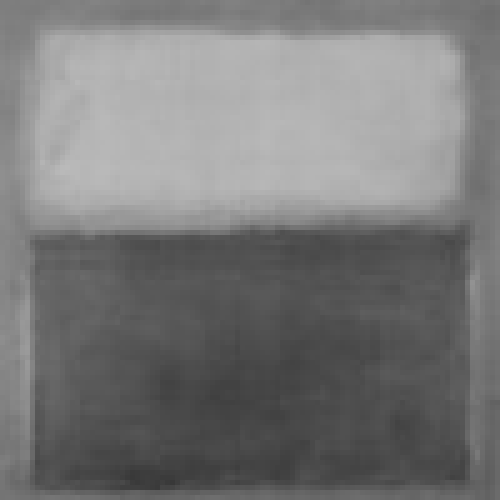

In [12]:
show_image(img)

In [13]:
def boundary_conditions_idx(f):    
    boundary_conditions_y = []
    boundary_conditions_x = []
    
    for y in range(f.shape[0]):
        boundary_conditions_y += [y, y]
        boundary_conditions_x += [0, f.shape[1] - 1]
    
    for x in range(f.shape[1]):
        boundary_conditions_y += [0, f.shape[0] - 1]
        boundary_conditions_x += [x, x]

    return boundary_conditions_y, boundary_conditions_x

In [16]:
class SecondOrderDiffEq:
    """
    A class that evaluates 2nd order diffential equations of 2 variables
    using a discrete finite difference
    """
    def __init__(self, weights=None):        
        # the 9 weights in the 2nd order PDE of 2 variables correspond to (in order):
        # constant, y, x, f, f_y, f_x, f_yy, f_yx, f_xx
        num_weights = 9
        
        if weights is None:
            weights = torch.randn(num_weights, requires_grad=True)
        
        assert len(weights) == num_weights
        self.weights = torch.tensor(weights, requires_grad=True)

    def freeze(self):
        """
        Returns a copy of the DiffEq with weights that don't require grad
        """
        res = SecondOrderDiffEq(self.weights.clone().detach())
        res.weights.requires_grad = False
        return res
    
    def _build_diff_mat_and_source(self, image, h=0.01):
        w_c, w_y, w_x, w_f, w_f_y, w_f_x, w_f_yy, w_f_yx, w_f_xx = self.weights

        height, width = image.shape
        n = height * width
    
        def idx(r, c):
            return r*width + c

        # figuring out the boundaries
        bound_y, bound_x = boundary_conditions_idx(image)
        boundaries = set(zip(bound_y, bound_x))    
    
        # building the differentiation matrix and source term
        diff_mat = torch.zeros((n, n))
        source = torch.zeros(n)

        for i in range(n):
            row = i // width
            col = i % width

            if (row, col) in boundaries:
                diff_mat[i][i] = 1
                source[i] = image[row][col]
                continue

            # computing the source term
            source[i] -= w_c
            source[i] -= w_x * col
            source[i] -= w_y * row

            # zero order f
            diff_mat[i][i] = w_f

            # first order f_x
            diff_mat[i, idx(row, col - 1)] -= w_f_x / (2 * h)
            diff_mat[i, idx(row, col + 1)] += w_f_x / (2 * h)

            # first order f_y
            diff_mat[i, idx(row - 1, col)] -= w_f_y / (2 * h)
            diff_mat[i, idx(row + 1, col)] += w_f_y / (2 * h)

            # second order f_xx
            diff_mat[i, idx(row, col - 1)] += w_f_xx / (h * h)
            diff_mat[i, idx(row, col)] -= 2 * w_f_xx / (h * h)
            diff_mat[i, idx(row, col + 1)] += w_f_xx / (h * h)

            # second order f_yy
            diff_mat[i, idx(row - 1, col)] += w_f_yy / (h * h)
            diff_mat[i, idx(row, col)] -= 2 * w_f_yy / (h * h)
            diff_mat[i, idx(row + 1, col)] += w_f_yy / (h * h)

            # second order f_yx
            diff_mat[i, idx(row + 1, col + 1)] += w_f_yx / (4 * h * h)
            diff_mat[i, idx(row - 1, col + 1)] -= w_f_yx / (4 * h * h)
            diff_mat[i, idx(row + 1, col - 1)] -= w_f_yx / (4 * h * h)
            diff_mat[i, idx(row - 1, col - 1)] += w_f_yx / (4 * h * h)
        
        return diff_mat, source
    
    def solve(self, orig_image):
        # we only use the `orig_image` for its shape and its boundary conditions
        diff_mat, source = self._build_diff_mat_and_source(orig_image)
        
        diff_mat = sp.csr_matrix(diff_mat.detach().numpy())
        source = source.detach().numpy()
        
        res = spl.spsolve(diff_mat, source)
        return torch.tensor(res.reshape(orig_image.shape))
    

    def __call__(self, f, h=0.01):
        """
        Evaluate this DiffEq with the given values of the function value `f`
        This uses a discrete finite difference.
        
        `f` should be a 2D torch.tensor
        """
        
        diff_mat, source = self._build_diff_mat_and_source(f, h)
        return (diff_mat @ f.flatten() - source).reshape(f.shape)

In [17]:
def harcode_boundary(image, internal_f):
    res = image.clone()
    assert res[1:-1, 1:-1].shape == internal_f.shape
    res[1:-1, 1:-1] = internal_f
    return res

def old_solve_diff_eq(image, diff_eq, num_epochs=100, lr=1):
    # set up the "learned" f
    internal_shape = (image.shape[0] - 2, image.shape[1] - 2)
    internal_f = torch.randn(internal_shape, requires_grad=True)

    # optimize `internal_f` to minimize the squared error of the diff_eq
    opt = torch.optim.LBFGS([internal_f], lr=lr)
    for i in range(num_epochs):
        try:
            opt.zero_grad()

            f = harcode_boundary(image, internal_f)
            loss = torch.sum(diff_eq(f) ** 2)
            loss.backward()
            opt.step(lambda: loss)

            if loss.detach() < 1e-8:
                break

            if i % 10 == 0:
                print(f'solve_diff_eq() epoch {i}: {loss.detach():.3g}')
        except KeyboardInterrupt:
            print('Stopping training early')
            break

    print(f'solve_diff_eq() epoch {i} loss: {loss.detach():.3g}')
    return f


In [28]:
def fit_diff_eq(image, num_epochs=1000, weight_penalty=2, lr=0.1):
    image = torch.tensor(image).double()

    diff_eq = SecondOrderDiffEq()

    opt = torch.optim.LBFGS([diff_eq.weights], lr=lr)
    for i in range(num_epochs):
        try:
            opt.zero_grad()

            loss = torch.sum(diff_eq(image) ** 2)
            loss += weight_penalty * torch.sum(1 / (diff_eq.weights.abs() + 1e-10))

            loss.backward()
            opt.step(lambda: loss)

            print(f'Epoch {i} loss: {loss.detach():.3g}')
        except KeyboardInterrupt:
            print('Stopping training early')
            break
        
    return diff_eq

In [39]:
def true_f(x, y):
    h = 0.01
    return np.exp(x*h) + np.exp(y*h)

# generate a fake image from f(x, y) = exp(x) + exp(y)
img = torch.zeros((10, 10))
for x in range(10):
    for y in range(10):
        img[x][y] = true_f(x, y)
img.shape

torch.Size([10, 10])

In [30]:
torch.manual_seed(2)
diff_eq = fit_diff_eq(img, num_epochs=200, weight_penalty=1)

Epoch 0 loss: 438
Epoch 1 loss: 335
Epoch 2 loss: 278
Epoch 3 loss: 232
Epoch 4 loss: 195
Epoch 5 loss: 165
Epoch 6 loss: 141
Epoch 7 loss: 121
Epoch 8 loss: 106
Epoch 9 loss: 93.2
Epoch 10 loss: 83
Epoch 11 loss: 74.8
Epoch 12 loss: 68.2
Epoch 13 loss: 62.9
Epoch 14 loss: 58.6
Epoch 15 loss: 55.2
Epoch 16 loss: 52.3
Epoch 17 loss: 50
Epoch 18 loss: 48
Epoch 19 loss: 46.4
Epoch 20 loss: 45
Epoch 21 loss: 43.8
Epoch 22 loss: 42.7
Epoch 23 loss: 41.8
Epoch 24 loss: 41.1
Epoch 25 loss: 40.4
Epoch 26 loss: 39.8
Epoch 27 loss: 39.2
Epoch 28 loss: 38.7
Epoch 29 loss: 38.3
Epoch 30 loss: 37.9
Epoch 31 loss: 37.6
Epoch 32 loss: 37.3
Epoch 33 loss: 37
Epoch 34 loss: 36.8
Epoch 35 loss: 36.5
Epoch 36 loss: 36.3
Epoch 37 loss: 36.2
Epoch 38 loss: 36
Epoch 39 loss: 35.8
Epoch 40 loss: 35.7
Epoch 41 loss: 35.5
Epoch 42 loss: 35.3
Epoch 43 loss: 35.2
Epoch 44 loss: 35
Epoch 45 loss: 34.8
Epoch 46 loss: 34.7
Epoch 47 loss: 34.6
Epoch 48 loss: 34.4
Epoch 49 loss: 34.3
Epoch 50 loss: 34.1
Epoch 51 loss

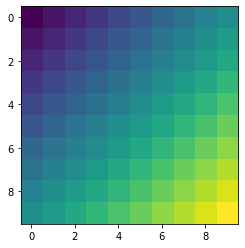

In [41]:
plt.imshow(img)

f error: tensor(2.1268e-15, grad_fn=<SumBackward0>)


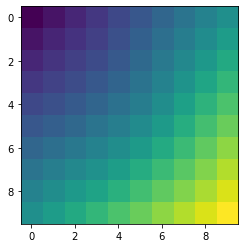

In [42]:
f = diff_eq.solve(img)
print('f error:', torch.sum(diff_eq(f) ** 2))
plt.imshow(f.detach().numpy());

In [43]:
img2 = torch.zeros((100, 100))
for x in range(100):
    for y in range(100):
        img2[x][y] = true_f(x, y)
img2.shape

torch.Size([100, 100])

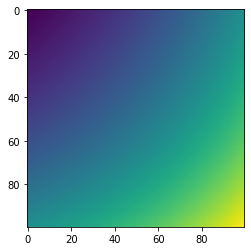

In [44]:
plt.imshow(img2)

In [45]:
f = diff_eq.solve(img2)

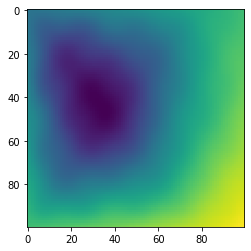

In [46]:
plt.imshow(f.detach().numpy())